<a href="https://colab.research.google.com/github/tushar-semwal/fedperf/blob/main/Vineeth/Local_Rounds/1/FederatedAveraging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
path = '/content/drive/MyDrive/Colab Notebooks/OpenMined/'
os.makedirs(path, exist_ok=True)

Mounted at /content/drive


## Imports

In [2]:
%load_ext tensorboard
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import copy
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, utils, datasets
from torchsummary import summary


# Check assigned GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

# set manual seed for reproducibility
seed = 42

# general reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# gpu training specific
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Sun Apr  4 10:00:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load the MNIST Dataset

In [3]:
# create transforms
# We will just convert to tensor and normalize since no special transforms are mentioned in the paper
transforms_mnist = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

mnist_data_train = datasets.MNIST('./data/mnist/', train=True, download=True, transform=transforms_mnist)
mnist_data_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=transforms_mnist)


Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw




Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw




Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw




Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)



Extracting ../data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../data/mnist/MNIST/raw




Extracting ../data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/mnist/MNIST/raw




Extracting ../data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/mnist/MNIST/raw




Extracting ../data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/mnist/MNIST/raw

Processing...
Done!


In [4]:
classes = np.array(list(mnist_data_train.class_to_idx.values()))
classes_test = np.array(list(mnist_data_test.class_to_idx.values()))
num_classes = len(classes_test)
print("Classes: {} \tType: {}".format(classes, type(classes)))
print("Classes Test: {} \tType: {}".format(classes_test, type(classes)))


Classes: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>
Classes Test: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>


In [5]:
print("Image Shape: {}".format(mnist_data_train.data[0].size()))

Image Shape: torch.Size([28, 28])


## Visualize Data

In [6]:
def imshow(img):
	img = img/2 + 0.5 #unnormalize the image
	plt.imshow(img, cmap='gray') # convert from tensor to image

In [7]:
def visualize(dataset):
  figure = plt.figure(figsize=(25,4))
  for i in range(20):
    axis = figure.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    data = dataset.data[i]
    data = data.numpy()

    target = dataset.targets[i]
    target = target.numpy()
    imshow(data)
    axis.set_title(target)


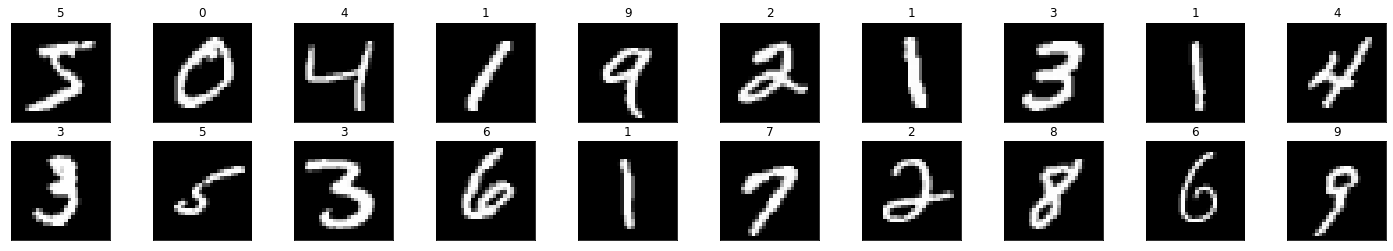

In [8]:
visualize(mnist_data_train)

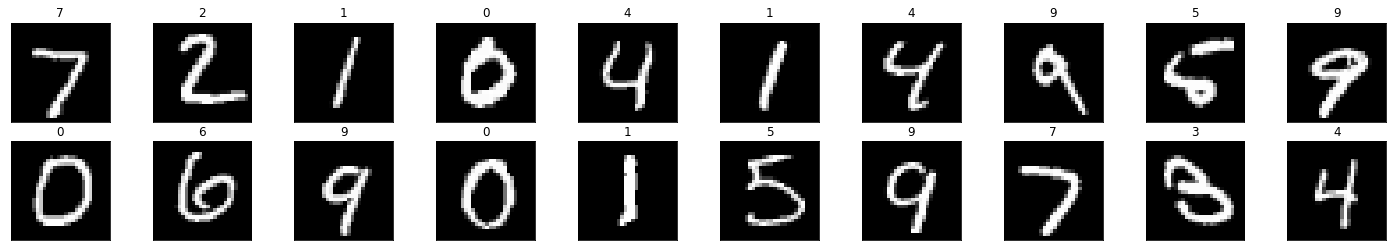

In [9]:
visualize(mnist_data_test)

## Partitioning the Data (IID and non-IID)

In [10]:
def iid_partition(dataset, clients):
  """
  I.I.D paritioning of data over clients
  Shuffle the data
  Split it between clients
  
  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between

  returns:
    - Dictionary of image indexes for each client
  """

  num_items_per_client = int(len(dataset)/clients)
  client_dict = {}
  image_idxs = [i for i in range(len(dataset))]

  for i in range(clients):
    client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
    image_idxs = list(set(image_idxs) - client_dict[i])

  return client_dict

In [11]:
def non_iid_partition(dataset, clients, total_shards, shards_size, num_shards_per_client):
  """
  non I.I.D parititioning of data over clients
  Sort the data by the digit label
  Divide the data into N shards of size S
  Each of the clients will get X shards

  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between
    - total_shards (int): Number of shards to partition the data in
    - shards_size (int): Size of each shard 
    - num_shards_per_client (int): Number of shards of size shards_size that each client receives

  returns:
    - Dictionary of image indexes for each client
  """
  
  shard_idxs = [i for i in range(total_shards)]
  client_dict = {i: np.array([], dtype='int64') for i in range(clients)}
  idxs = np.arange(len(dataset))
  data_labels = dataset.targets.numpy()

  # sort the labels
  label_idxs = np.vstack((idxs, data_labels))
  label_idxs = label_idxs[:, label_idxs[1,:].argsort()]
  idxs = label_idxs[0,:]

  # divide the data into total_shards of size shards_size
  # assign num_shards_per_client to each client
  for i in range(clients):
    rand_set = set(np.random.choice(shard_idxs, num_shards_per_client, replace=False))
    shard_idxs = list(set(shard_idxs) - rand_set)

    for rand in rand_set:
      client_dict[i] = np.concatenate((client_dict[i], idxs[rand*shards_size:(rand+1)*shards_size]), axis=0)
  
  return client_dict





## Models

In [12]:
class MNIST_2NN(nn.Module):
  """
  A simple multilayer-perceptron with 2-hidden layers with 200 units each
  using ReLu activations

  Total Expected Params: 199,210
  """
  def __init__(self):
    super(MNIST_2NN, self).__init__()

    self.fc1 = nn.Linear(28*28, 200)
    self.fc2 = nn.Linear(200, 200)
    self.fc3 = nn.Linear(200, 10)

  def forward(self, x):
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    out = self.fc3(x)

    return x

In [13]:
class MNIST_CNN(nn.Module):
  """
  CNN with two 5x5 convolution lauers(the first with 32 channels, second with 64,
  each followed with 2x2 max pooling), a fully connected layer with 512 uunits and 
  ReLu activation, and the final Softmax output layer

  Total Expected Params: 1,663,370
  """
  def __init__(self):
    super(MNIST_CNN, self).__init__()

    self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
    
    self.pool = nn.MaxPool2d(2,2)
    self.dropout = nn.Dropout(p=0.2)

    self.fc1 = nn.Linear(1024, 512)
    self.out = nn.Linear(512, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.dropout(x)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.out(x)
    out = F.log_softmax(x, dim=1)

    return out

### Print Model Summaries

In [14]:
mnist_mlp = MNIST_2NN()
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_mlp.cuda()
  mnist_cnn.cuda()

print("MNIST MLP SUMMARY")
print(summary(mnist_mlp, (28,28)))

print("\nMNIST CNN SUMMARY")
print(summary(mnist_cnn, (1, 28,28)))

MNIST MLP SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 200]         157,000
            Linear-2                  [-1, 200]          40,200
            Linear-3                   [-1, 10]           2,010
Total params: 199,210
Trainable params: 199,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.76
Estimated Total Size (MB): 0.77
----------------------------------------------------------------
None

MNIST CNN SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
         MaxPool2d-2           [-1, 32, 12, 12]               0
            Conv2d-3             [-1, 64, 8, 8]          51,264

## Federated Averaging

### Local Training (Client Update)

Local training for the model on client side

In [15]:
class CustomDataset(Dataset):
  def __init__(self, dataset, idxs):
      self.dataset = dataset
      self.idxs = list(idxs)

  def __len__(self):
      return len(self.idxs)

  def __getitem__(self, item):
      image, label = self.dataset[self.idxs[item]]
      return image, label


class ClientUpdate(object):
  def __init__(self, dataset, batchSize, learning_rate, epochs, idxs):
    self.train_loader = DataLoader(CustomDataset(dataset, idxs), batch_size=batchSize, shuffle=True)

    self.learning_rate = learning_rate
    self.epochs = epochs

  def train(self, model):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate, momentum=0.5)
    # optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate)

    e_loss = []
    for epoch in range(1, self.epochs+1):

      train_loss = 0.0
      model.train()
      for data, labels in self.train_loader:

        if torch.cuda.is_available():
          data, labels = data.cuda(), labels.cuda()

        # clear the gradients
        optimizer.zero_grad()
        # make a forward pass
        output = model(data)
        # calculate the loss
        loss = criterion(output, labels)
        # do a backwards pass
        loss.backward()
        # perform a single optimization step
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

      # average losses
      train_loss = train_loss/len(self.train_loader.dataset)
      e_loss.append(train_loss)

    total_loss = sum(e_loss)/len(e_loss)

    return model.state_dict(), total_loss

### Server Side Training

Following Algorithm 1 from the paper

In [16]:
def training(model, rounds, batch_size, lr, ds, ds_test, data_dict, C, K, E, plt_title, plt_color):
  """
  Function implements the Federated Averaging Algorithm from the FedAvg paper.
  Specifically, this function is used for the server side training and weight update

  Params:
    - model:           PyTorch model to train
    - rounds:          Number of communication rounds for the client update
    - batch_size:      Batch size for client update training
    - lr:              Learning rate used for client update training
    - ds:              Dataset used for training
    - ds_test:         Dataset used for testing
    - data_dict:       Type of data partition used for training (IID or non-IID)
    - C:               Fraction of clients randomly chosen to perform computation on each round
    - K:               Total number of clients
    - E:               Number of training passes each client makes over its local dataset per round
    - tb_writer_name:  Directory name to save the tensorboard logs
  Returns:
    - model:           Trained model on the server
  """

  # global model weights
  global_weights = model.state_dict()

  # training loss
  # train_accuracy = []
  train_loss = []
  test_accuracy = []
  test_loss = []


  # measure time
  start = time.time()

  for curr_round in range(1, rounds+1):
    w, local_loss = [], []

    m = max(int(C*K), 1)
    
    S_t = np.random.choice(range(K), m, replace=False)
    for k in S_t:
      local_update = ClientUpdate(dataset=ds, batchSize=batch_size, learning_rate=lr, epochs=E, idxs=data_dict[k])
      weights, loss = local_update.train(model=copy.deepcopy(model))

      w.append(copy.deepcopy(weights))
      local_loss.append(copy.deepcopy(loss))

    # updating the global weights
    weights_avg = copy.deepcopy(w[0])
    for k in weights_avg.keys():
      for i in range(1, len(w)):
        weights_avg[k] += w[i][k]

      weights_avg[k] = torch.div(weights_avg[k], len(w))

    global_weights = weights_avg

    # move the updated weights to our model state dict
    model.load_state_dict(global_weights)

    # loss
    loss_avg = sum(local_loss) / len(local_loss)
    print('Round: {}... \tAverage Loss: {}'.format(curr_round, round(loss_avg, 3)))
    train_loss.append(loss_avg)

    # test
    test_criterion = nn.CrossEntropyLoss()
    test_accuracy_current, test_loss_current =  testing(copy.deepcopy(model), ds_test, 128, test_criterion, num_classes, classes_test)
    test_accuracy.append(test_accuracy_current)
    test_loss.append(test_loss_current)

  end = time.time()
  
  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(train_loss)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Train Loss',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'_Train_loss.jpg', format='jpg')
  plt.show()

  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(test_loss)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Test Loss',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'_Test_loss.jpg', format='jpg')
  plt.show()

  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(test_accuracy)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Test Accuracy',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'_Test_Accuracy.jpg', format='jpg')
  plt.show()
  
  print("Training Done!")
  print("Total time taken to Train: {}\n\n".format(end-start))
  
  return model, train_loss, test_accuracy, test_loss

## Testing Loop

In [17]:
def testing(model, dataset, bs, criterion, num_classes, classes, print_info=False):
  #test loss 
  test_loss = 0.0
  correct_class = list(0. for i in range(num_classes))
  total_class = list(0. for i in range(num_classes))

  test_loader = DataLoader(dataset, batch_size=bs)
  l = len(test_loader)
  model.eval()
  for data, labels in test_loader:

    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()

    output = model(data)
    loss = criterion(output, labels)
    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, 1)

    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())

    #test accuracy for each object class
    for i in range(num_classes):
      label = labels.data[i]
      correct_class[label] += correct[i].item()
      total_class[label] += 1
    
  # avg test loss
  test_loss = test_loss/len(test_loader.dataset)
  test_accuracy = 100. * np.sum(correct_class) / np.sum(total_class)

  if print_info:
    print("Test Loss: {:.6f}\n".format(test_loss))

    for i in range(10):
      if total_class[i]>0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % 
              (classes[i], 100 * correct_class[i] / total_class[i],
              np.sum(correct_class[i]), np.sum(total_class[i])))
      else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nFinal Test  Accuracy: {:.3f} ({}/{})'.format(
          100. * np.sum(correct_class) / np.sum(total_class),
          np.sum(correct_class), np.sum(total_class)))
  
  return test_accuracy, test_loss

## Logger

In [18]:
log_dict = {}
NUM_REPEAT = 5

## MNIST CNN on IID

### Train


Experiment Run Number:  0
Round: 1... 	Average Loss: 1.613
Round: 2... 	Average Loss: 0.914
Round: 3... 	Average Loss: 0.507
Round: 4... 	Average Loss: 0.345
Round: 5... 	Average Loss: 0.311
Round: 6... 	Average Loss: 0.253
Round: 7... 	Average Loss: 0.204
Round: 8... 	Average Loss: 0.21
Round: 9... 	Average Loss: 0.184
Round: 10... 	Average Loss: 0.161
Round: 11... 	Average Loss: 0.148
Round: 12... 	Average Loss: 0.173
Round: 13... 	Average Loss: 0.111
Round: 14... 	Average Loss: 0.151
Round: 15... 	Average Loss: 0.118
Round: 16... 	Average Loss: 0.124
Round: 17... 	Average Loss: 0.11
Round: 18... 	Average Loss: 0.102
Round: 19... 	Average Loss: 0.082
Round: 20... 	Average Loss: 0.109
Round: 21... 	Average Loss: 0.098
Round: 22... 	Average Loss: 0.097
Round: 23... 	Average Loss: 0.065
Round: 24... 	Average Loss: 0.096
Round: 25... 	Average Loss: 0.083
Round: 26... 	Average Loss: 0.069
Round: 27... 	Average Loss: 0.087
Round: 28... 	Average Loss: 0.066
Round: 29... 	Average Loss: 0.088

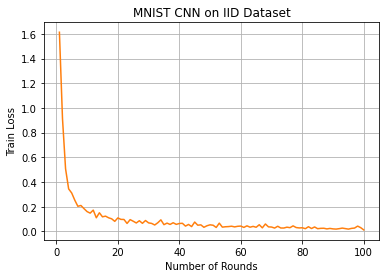

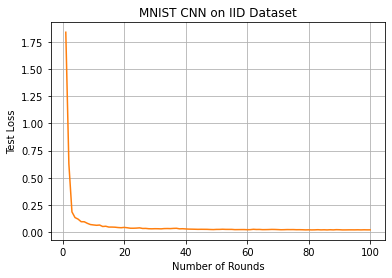

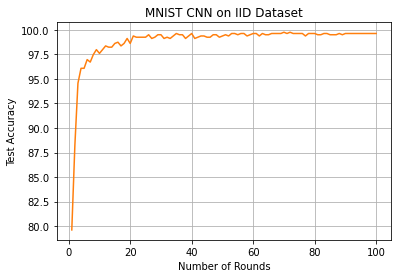

Training Done!
Total time taken to Train: 493.1438465118408


Experiment Run Number:  1
Round: 1... 	Average Loss: 1.684
Round: 2... 	Average Loss: 1.006
Round: 3... 	Average Loss: 0.58
Round: 4... 	Average Loss: 0.383
Round: 5... 	Average Loss: 0.336
Round: 6... 	Average Loss: 0.272
Round: 7... 	Average Loss: 0.206
Round: 8... 	Average Loss: 0.231
Round: 9... 	Average Loss: 0.207
Round: 10... 	Average Loss: 0.174
Round: 11... 	Average Loss: 0.163
Round: 12... 	Average Loss: 0.159
Round: 13... 	Average Loss: 0.129
Round: 14... 	Average Loss: 0.147
Round: 15... 	Average Loss: 0.143
Round: 16... 	Average Loss: 0.145
Round: 17... 	Average Loss: 0.124
Round: 18... 	Average Loss: 0.149
Round: 19... 	Average Loss: 0.09
Round: 20... 	Average Loss: 0.117
Round: 21... 	Average Loss: 0.079
Round: 22... 	Average Loss: 0.105
Round: 23... 	Average Loss: 0.086
Round: 24... 	Average Loss: 0.097
Round: 25... 	Average Loss: 0.095
Round: 26... 	Average Loss: 0.086
Round: 27... 	Average Loss: 0.081
Round

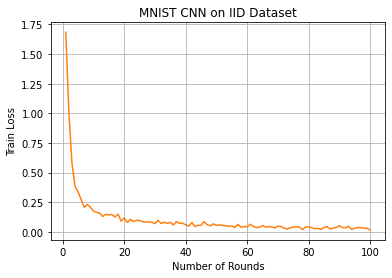

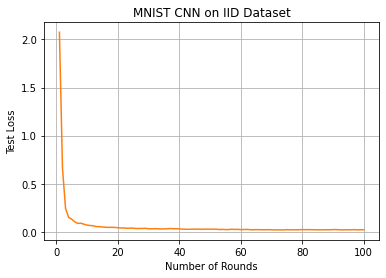

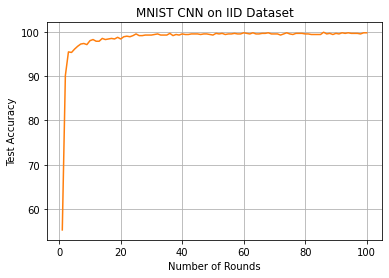

Training Done!
Total time taken to Train: 496.3817732334137


Experiment Run Number:  2
Round: 1... 	Average Loss: 1.606
Round: 2... 	Average Loss: 0.964
Round: 3... 	Average Loss: 0.498
Round: 4... 	Average Loss: 0.364
Round: 5... 	Average Loss: 0.278
Round: 6... 	Average Loss: 0.235
Round: 7... 	Average Loss: 0.235
Round: 8... 	Average Loss: 0.185
Round: 9... 	Average Loss: 0.195
Round: 10... 	Average Loss: 0.199
Round: 11... 	Average Loss: 0.156
Round: 12... 	Average Loss: 0.135
Round: 13... 	Average Loss: 0.165
Round: 14... 	Average Loss: 0.127
Round: 15... 	Average Loss: 0.115
Round: 16... 	Average Loss: 0.115
Round: 17... 	Average Loss: 0.103
Round: 18... 	Average Loss: 0.11
Round: 19... 	Average Loss: 0.094
Round: 20... 	Average Loss: 0.103
Round: 21... 	Average Loss: 0.102
Round: 22... 	Average Loss: 0.081
Round: 23... 	Average Loss: 0.076
Round: 24... 	Average Loss: 0.078
Round: 25... 	Average Loss: 0.066
Round: 26... 	Average Loss: 0.085
Round: 27... 	Average Loss: 0.079
Roun

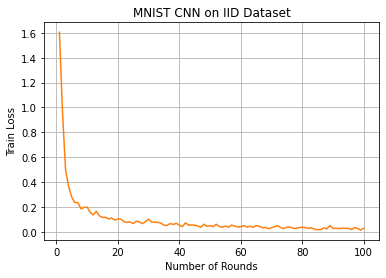

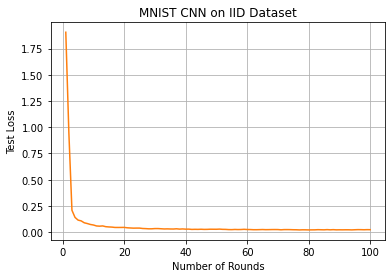

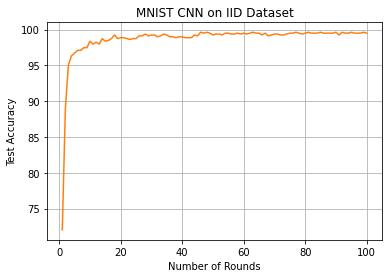

Training Done!
Total time taken to Train: 490.955219745636


Experiment Run Number:  3
Round: 1... 	Average Loss: 1.659
Round: 2... 	Average Loss: 1.02
Round: 3... 	Average Loss: 0.559
Round: 4... 	Average Loss: 0.401
Round: 5... 	Average Loss: 0.312
Round: 6... 	Average Loss: 0.269
Round: 7... 	Average Loss: 0.223
Round: 8... 	Average Loss: 0.202
Round: 9... 	Average Loss: 0.205
Round: 10... 	Average Loss: 0.196
Round: 11... 	Average Loss: 0.159
Round: 12... 	Average Loss: 0.159
Round: 13... 	Average Loss: 0.139
Round: 14... 	Average Loss: 0.14
Round: 15... 	Average Loss: 0.134
Round: 16... 	Average Loss: 0.126
Round: 17... 	Average Loss: 0.131
Round: 18... 	Average Loss: 0.103
Round: 19... 	Average Loss: 0.126
Round: 20... 	Average Loss: 0.124
Round: 21... 	Average Loss: 0.114
Round: 22... 	Average Loss: 0.105
Round: 23... 	Average Loss: 0.09
Round: 24... 	Average Loss: 0.099
Round: 25... 	Average Loss: 0.089
Round: 26... 	Average Loss: 0.081
Round: 27... 	Average Loss: 0.107
Round: 

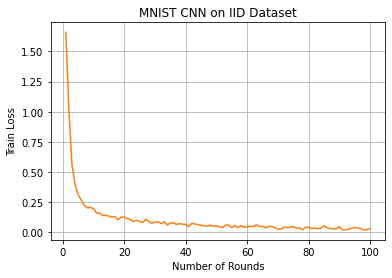

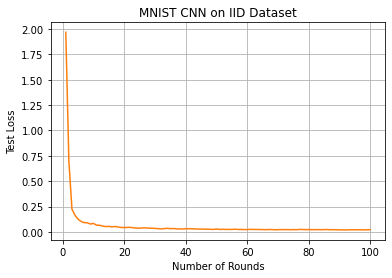

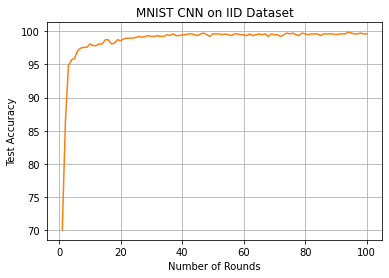

Training Done!
Total time taken to Train: 489.3405029773712


Experiment Run Number:  4
Round: 1... 	Average Loss: 1.624
Round: 2... 	Average Loss: 0.946
Round: 3... 	Average Loss: 0.501
Round: 4... 	Average Loss: 0.38
Round: 5... 	Average Loss: 0.291
Round: 6... 	Average Loss: 0.241
Round: 7... 	Average Loss: 0.216
Round: 8... 	Average Loss: 0.223
Round: 9... 	Average Loss: 0.179
Round: 10... 	Average Loss: 0.174
Round: 11... 	Average Loss: 0.154
Round: 12... 	Average Loss: 0.165
Round: 13... 	Average Loss: 0.145
Round: 14... 	Average Loss: 0.118
Round: 15... 	Average Loss: 0.114
Round: 16... 	Average Loss: 0.129
Round: 17... 	Average Loss: 0.135
Round: 18... 	Average Loss: 0.093
Round: 19... 	Average Loss: 0.111
Round: 20... 	Average Loss: 0.091
Round: 21... 	Average Loss: 0.107
Round: 22... 	Average Loss: 0.084
Round: 23... 	Average Loss: 0.093
Round: 24... 	Average Loss: 0.119
Round: 25... 	Average Loss: 0.074
Round: 26... 	Average Loss: 0.072
Round: 27... 	Average Loss: 0.075
Roun

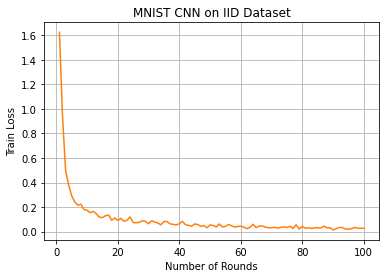

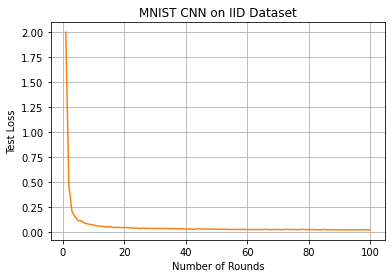

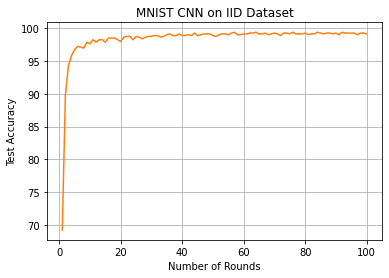

Training Done!
Total time taken to Train: 486.6001889705658




In [19]:
train_loss_multiple_runs = [None] * NUM_REPEAT
test_accuracy_multiple_runs = [None] * NUM_REPEAT
test_loss_multiple_runs = [None] * NUM_REPEAT

for exp_num in range(NUM_REPEAT):
  print("Experiment Run Number: ", exp_num)

  # number of training rounds
  rounds = 100
  # client fraction
  C = 0.1
  # number of clients
  K = 100
  # number of training passes on local dataset for each roung
  E = 1
  # batch size
  batch_size = 10
  # learning Rate
  lr=0.1
  # data partition dictionary
  iid_dict = iid_partition(mnist_data_train, 100)
  # load model
  mnist_cnn = MNIST_CNN()

  if torch.cuda.is_available():
    mnist_cnn.cuda()

  mnist_cnn_iid_trained, train_loss, test_accuracy, test_loss = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, mnist_data_test, iid_dict, C, K, E, "MNIST CNN on IID Dataset", "orange")

  train_loss_multiple_runs[exp_num] = train_loss
  test_accuracy_multiple_runs[exp_num] = test_accuracy
  test_loss_multiple_runs[exp_num] = test_loss

### Test

In [20]:
criterion = nn.CrossEntropyLoss() 
acc, loss = testing(mnist_cnn_iid_trained, mnist_data_test, 128, criterion, num_classes, classes_test, True)

Test Loss: 0.021610

Test Accuracy of     0: 100% (76/76)
Test Accuracy of     1: 100% (90/90)
Test Accuracy of     2: 98% (90/91)
Test Accuracy of     3: 97% (71/73)
Test Accuracy of     4: 100% (89/89)
Test Accuracy of     5: 98% (67/68)
Test Accuracy of     6: 96% (60/62)
Test Accuracy of     7: 100% (81/81)
Test Accuracy of     8: 100% (77/77)
Test Accuracy of     9: 98% (82/83)

Final Test  Accuracy: 99.114 (783.0/790.0)


In [21]:
hyperparams = {'rounds': rounds,
               'C': C,
               'K': K,
               'E': E,
               'batch_size': batch_size,
               'lr': lr,
               }

log_dict['MNIST CNN on IID'] = {'train_loss': train_loss_multiple_runs, 
                                'test_loss': test_loss_multiple_runs, 
                                'test_accuracy': test_accuracy_multiple_runs,
                                'hyperparams': hyperparams,
                                }

## MNIST CNN on Non IID

### Train


Experiment Run Number:  0
Round: 1... 	Average Loss: 1.877
Round: 2... 	Average Loss: 0.959
Round: 3... 	Average Loss: 0.722
Round: 4... 	Average Loss: 0.929
Round: 5... 	Average Loss: 0.512
Round: 6... 	Average Loss: 0.289
Round: 7... 	Average Loss: 0.254
Round: 8... 	Average Loss: 0.194
Round: 9... 	Average Loss: 0.205
Round: 10... 	Average Loss: 0.127
Round: 11... 	Average Loss: 0.186
Round: 12... 	Average Loss: 0.117
Round: 13... 	Average Loss: 0.129
Round: 14... 	Average Loss: 0.269
Round: 15... 	Average Loss: 0.143
Round: 16... 	Average Loss: 0.115
Round: 17... 	Average Loss: 0.198
Round: 18... 	Average Loss: 0.157
Round: 19... 	Average Loss: 0.171
Round: 20... 	Average Loss: 0.133
Round: 21... 	Average Loss: 0.15
Round: 22... 	Average Loss: 0.124
Round: 23... 	Average Loss: 0.157
Round: 24... 	Average Loss: 0.152
Round: 25... 	Average Loss: 0.146
Round: 26... 	Average Loss: 0.12
Round: 27... 	Average Loss: 0.086
Round: 28... 	Average Loss: 0.176
Round: 29... 	Average Loss: 0.125

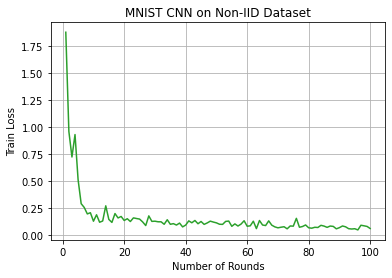

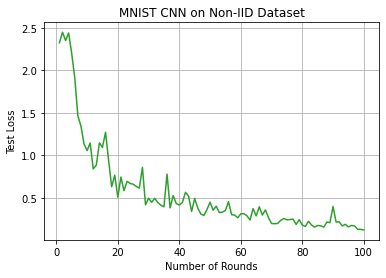

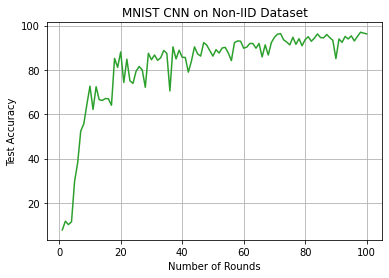

Training Done!
Total time taken to Train: 470.43539905548096


Experiment Run Number:  1
Round: 1... 	Average Loss: 0.632
Round: 2... 	Average Loss: 0.766
Round: 3... 	Average Loss: 0.382
Round: 4... 	Average Loss: 0.303
Round: 5... 	Average Loss: 0.276
Round: 6... 	Average Loss: 0.182
Round: 7... 	Average Loss: 0.17
Round: 8... 	Average Loss: 0.13
Round: 9... 	Average Loss: 0.161
Round: 10... 	Average Loss: 0.086
Round: 11... 	Average Loss: 0.125
Round: 12... 	Average Loss: 0.108
Round: 13... 	Average Loss: 0.104
Round: 14... 	Average Loss: 0.125
Round: 15... 	Average Loss: 0.067
Round: 16... 	Average Loss: 0.085
Round: 17... 	Average Loss: 0.351
Round: 18... 	Average Loss: 0.082
Round: 19... 	Average Loss: 0.092
Round: 20... 	Average Loss: 0.065
Round: 21... 	Average Loss: 0.067
Round: 22... 	Average Loss: 0.048
Round: 23... 	Average Loss: 0.064
Round: 24... 	Average Loss: 0.047
Round: 25... 	Average Loss: 0.065
Round: 26... 	Average Loss: 0.054
Round: 27... 	Average Loss: 0.041
Roun

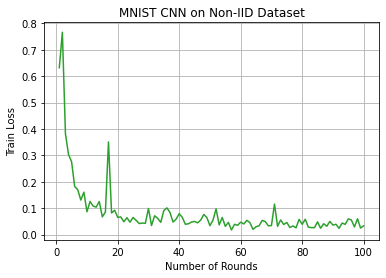

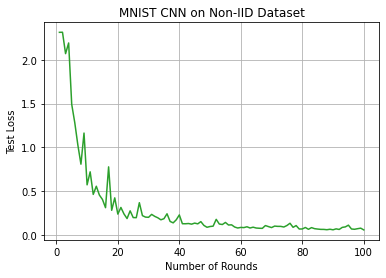

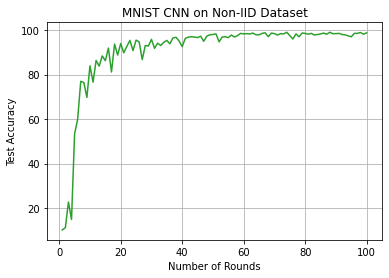

Training Done!
Total time taken to Train: 470.6684236526489


Experiment Run Number:  2
Round: 1... 	Average Loss: nan
Round: 2... 	Average Loss: nan
Round: 3... 	Average Loss: nan
Round: 4... 	Average Loss: nan
Round: 5... 	Average Loss: nan
Round: 6... 	Average Loss: nan
Round: 7... 	Average Loss: nan
Round: 8... 	Average Loss: nan
Round: 9... 	Average Loss: nan
Round: 10... 	Average Loss: nan
Round: 11... 	Average Loss: nan
Round: 12... 	Average Loss: nan
Round: 13... 	Average Loss: nan
Round: 14... 	Average Loss: nan
Round: 15... 	Average Loss: nan
Round: 16... 	Average Loss: nan
Round: 17... 	Average Loss: nan
Round: 19... 	Average Loss: nan
Round: 20... 	Average Loss: nan
Round: 21... 	Average Loss: nan
Round: 22... 	Average Loss: nan
Round: 23... 	Average Loss: nan
Round: 24... 	Average Loss: nan
Round: 25... 	Average Loss: nan
Round: 26... 	Average Loss: nan
Round: 27... 	Average Loss: nan
Round: 28... 	Average Loss: nan
Round: 29... 	Average Loss: nan
Round: 30... 	Average Los

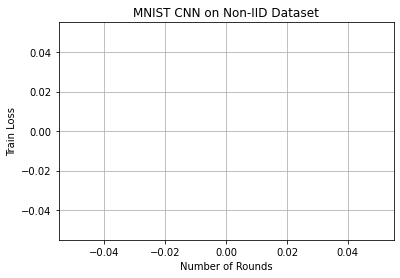

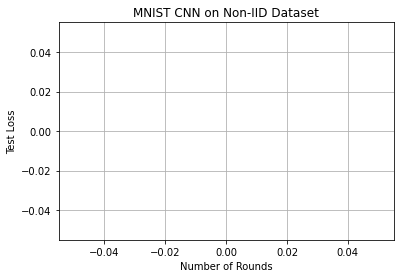

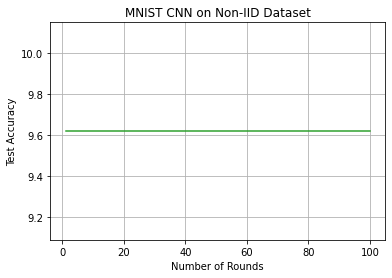

Training Done!
Total time taken to Train: 471.1606938838959


Experiment Run Number:  3
Round: 1... 	Average Loss: 1.007
Round: 2... 	Average Loss: 0.689
Round: 3... 	Average Loss: 0.511
Round: 4... 	Average Loss: 0.319
Round: 5... 	Average Loss: 0.202
Round: 6... 	Average Loss: 0.215
Round: 7... 	Average Loss: 0.156
Round: 8... 	Average Loss: 0.14
Round: 9... 	Average Loss: 0.163
Round: 10... 	Average Loss: 0.112
Round: 11... 	Average Loss: 0.106
Round: 12... 	Average Loss: 0.147
Round: 13... 	Average Loss: 0.123
Round: 14... 	Average Loss: 0.131
Round: 15... 	Average Loss: 0.122
Round: 16... 	Average Loss: 0.183
Round: 17... 	Average Loss: 0.123
Round: 18... 	Average Loss: 0.088
Round: 19... 	Average Loss: 0.091
Round: 20... 	Average Loss: 0.08
Round: 21... 	Average Loss: 0.075
Round: 22... 	Average Loss: 0.065
Round: 23... 	Average Loss: 0.148
Round: 24... 	Average Loss: 0.093
Round: 25... 	Average Loss: 0.095
Round: 26... 	Average Loss: 0.083
Round: 27... 	Average Loss: 0.057
Round

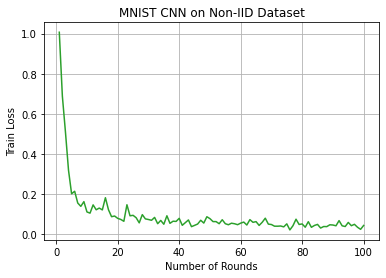

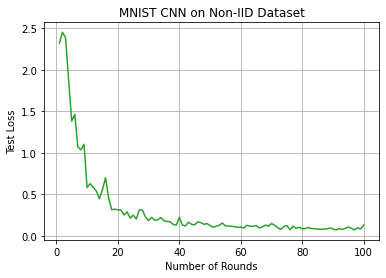

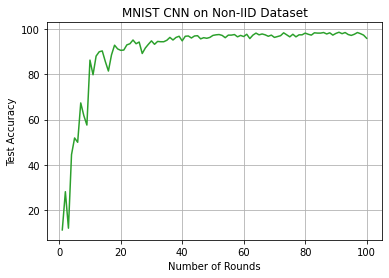

Training Done!
Total time taken to Train: 471.1183063983917


Experiment Run Number:  4
Round: 1... 	Average Loss: 0.983
Round: 2... 	Average Loss: 0.856
Round: 3... 	Average Loss: 0.297
Round: 4... 	Average Loss: 0.248
Round: 5... 	Average Loss: 0.242
Round: 6... 	Average Loss: 0.211
Round: 7... 	Average Loss: 0.172
Round: 8... 	Average Loss: 0.176
Round: 9... 	Average Loss: 0.133
Round: 10... 	Average Loss: 0.13
Round: 11... 	Average Loss: 0.176
Round: 12... 	Average Loss: 0.083
Round: 13... 	Average Loss: 0.284
Round: 14... 	Average Loss: 0.106
Round: 15... 	Average Loss: 0.123
Round: 16... 	Average Loss: 0.095
Round: 17... 	Average Loss: 0.118
Round: 18... 	Average Loss: 0.082
Round: 19... 	Average Loss: 0.148
Round: 20... 	Average Loss: 0.092
Round: 21... 	Average Loss: 0.078
Round: 22... 	Average Loss: 0.136
Round: 23... 	Average Loss: 0.116
Round: 24... 	Average Loss: 0.093
Round: 25... 	Average Loss: 0.116
Round: 26... 	Average Loss: 0.057
Round: 27... 	Average Loss: 0.088
Roun

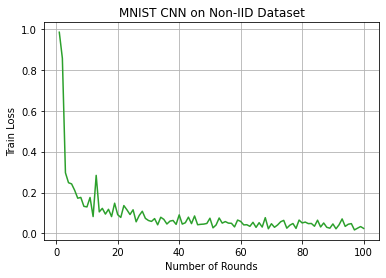

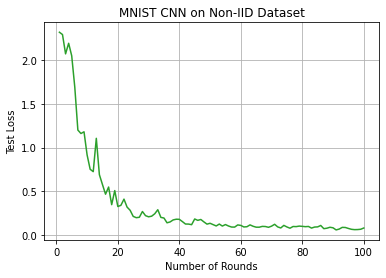

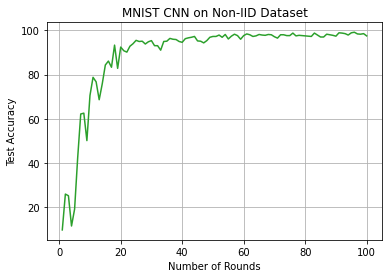

Training Done!
Total time taken to Train: 471.0399012565613




In [22]:
train_loss_multiple_runs = [None] * NUM_REPEAT
test_accuracy_multiple_runs = [None] * NUM_REPEAT
test_loss_multiple_runs = [None] * NUM_REPEAT

for exp_num in range(NUM_REPEAT):
  print("Experiment Run Number: ", exp_num)

  # number of training rounds
  rounds = 100
  # client fraction
  C = 0.1
  # number of clients
  K = 100
  # number of training passes on local dataset for each roung
  E = 1
  # batch size
  batch_size = 10
  # learning Rate
  lr=0.1
  # dict containing different type of data partition
  data_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)
  # load model
  mnist_cnn = MNIST_CNN()

  if torch.cuda.is_available():
    mnist_cnn.cuda()

  mnist_cnn_non_iid_trained, train_loss, test_accuracy, test_loss = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, mnist_data_test, data_dict, C, K, E, "MNIST CNN on Non-IID Dataset", "green")

  train_loss_multiple_runs[exp_num] = train_loss
  test_accuracy_multiple_runs[exp_num] = test_accuracy
  test_loss_multiple_runs[exp_num] = test_loss

### Test

In [23]:
criterion = nn.CrossEntropyLoss() 
acc, loss = testing(mnist_cnn_non_iid_trained, mnist_data_test, 128, criterion, num_classes, classes_test, True)

Test Loss: 0.078484

Test Accuracy of     0: 100% (76/76)
Test Accuracy of     1: 96% (87/90)
Test Accuracy of     2: 97% (89/91)
Test Accuracy of     3: 95% (70/73)
Test Accuracy of     4: 100% (89/89)
Test Accuracy of     5: 98% (67/68)
Test Accuracy of     6: 98% (61/62)
Test Accuracy of     7: 100% (81/81)
Test Accuracy of     8: 90% (70/77)
Test Accuracy of     9: 96% (80/83)

Final Test  Accuracy: 97.468 (770.0/790.0)


In [24]:
hyperparams = {'rounds': rounds,
               'C': C,
               'K': K,
               'E': E,
               'batch_size': batch_size,
               'lr': lr,
               }

log_dict['MNIST CNN on Non IID'] = {'train_loss': train_loss_multiple_runs, 
                                'test_loss': test_loss_multiple_runs, 
                                'test_accuracy': test_accuracy_multiple_runs,
                                'hyperparams': hyperparams,
                                }

## MNIST MLP on IID

### Train

Experiment Run Number:  0
Round: 1... 	Average Loss: 2.357
Round: 2... 	Average Loss: 1.078
Round: 3... 	Average Loss: 0.77
Round: 4... 	Average Loss: 0.622
Round: 5... 	Average Loss: 0.517
Round: 6... 	Average Loss: 0.448
Round: 7... 	Average Loss: 0.443
Round: 8... 	Average Loss: 0.396
Round: 9... 	Average Loss: 0.342
Round: 10... 	Average Loss: 0.34
Round: 11... 	Average Loss: 0.345
Round: 12... 	Average Loss: 0.32
Round: 13... 	Average Loss: 0.267
Round: 14... 	Average Loss: 0.226
Round: 15... 	Average Loss: 0.264
Round: 16... 	Average Loss: 0.259
Round: 17... 	Average Loss: 0.234
Round: 18... 	Average Loss: 0.212
Round: 19... 	Average Loss: 0.198
Round: 20... 	Average Loss: 0.207
Round: 21... 	Average Loss: 0.208
Round: 22... 	Average Loss: 0.177
Round: 23... 	Average Loss: 0.18
Round: 24... 	Average Loss: 0.21
Round: 25... 	Average Loss: 0.205
Round: 26... 	Average Loss: 0.154
Round: 27... 	Average Loss: 0.148
Round: 28... 	Average Loss: 0.135
Round: 29... 	Average Loss: 0.195
Ro

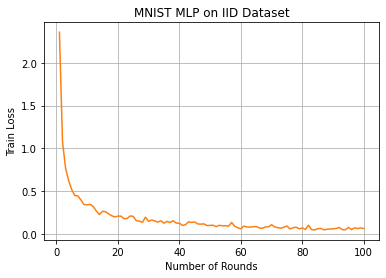

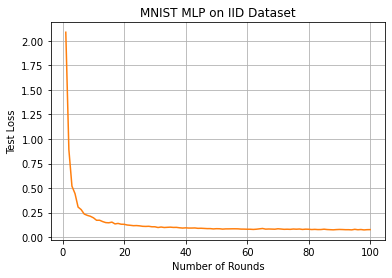

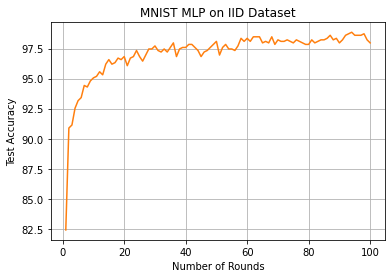

Training Done!
Total time taken to Train: 393.0053503513336


Experiment Run Number:  1
Round: 1... 	Average Loss: 2.245
Round: 2... 	Average Loss: 1.063
Round: 3... 	Average Loss: 0.745
Round: 4... 	Average Loss: 0.614
Round: 5... 	Average Loss: 0.501
Round: 6... 	Average Loss: 0.452
Round: 7... 	Average Loss: 0.46
Round: 8... 	Average Loss: 0.346
Round: 9... 	Average Loss: 0.36
Round: 10... 	Average Loss: 0.295
Round: 11... 	Average Loss: 0.351
Round: 12... 	Average Loss: 0.273
Round: 13... 	Average Loss: 0.26
Round: 14... 	Average Loss: 0.303
Round: 15... 	Average Loss: 0.248
Round: 16... 	Average Loss: 0.23
Round: 17... 	Average Loss: 0.263
Round: 18... 	Average Loss: 0.225
Round: 19... 	Average Loss: 0.206
Round: 20... 	Average Loss: 0.196
Round: 21... 	Average Loss: 0.19
Round: 22... 	Average Loss: 0.196
Round: 23... 	Average Loss: 0.203
Round: 24... 	Average Loss: 0.195
Round: 25... 	Average Loss: 0.141
Round: 26... 	Average Loss: 0.202
Round: 27... 	Average Loss: 0.182
Round: 2

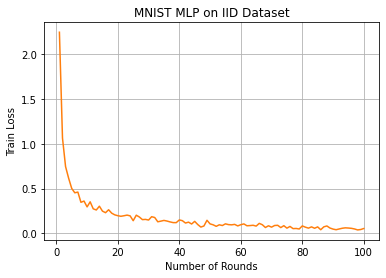

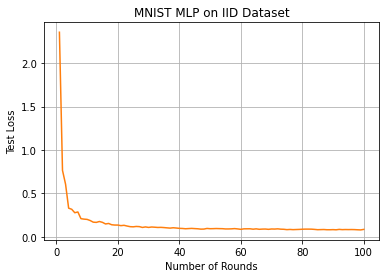

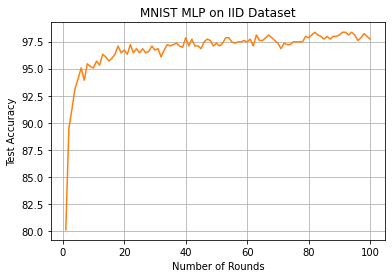

Training Done!
Total time taken to Train: 394.0021719932556


Experiment Run Number:  2
Round: 1... 	Average Loss: 2.423
Round: 2... 	Average Loss: 1.083
Round: 3... 	Average Loss: 0.725
Round: 4... 	Average Loss: 0.568
Round: 5... 	Average Loss: 0.556
Round: 6... 	Average Loss: 0.479
Round: 7... 	Average Loss: 0.424
Round: 8... 	Average Loss: 0.378
Round: 9... 	Average Loss: 0.331
Round: 10... 	Average Loss: 0.372
Round: 11... 	Average Loss: 0.349
Round: 12... 	Average Loss: 0.279
Round: 13... 	Average Loss: 0.291
Round: 14... 	Average Loss: 0.254
Round: 15... 	Average Loss: 0.256
Round: 16... 	Average Loss: 0.237
Round: 17... 	Average Loss: 0.207
Round: 18... 	Average Loss: 0.254
Round: 19... 	Average Loss: 0.225
Round: 20... 	Average Loss: 0.192
Round: 21... 	Average Loss: 0.212
Round: 22... 	Average Loss: 0.194
Round: 23... 	Average Loss: 0.195
Round: 24... 	Average Loss: 0.17
Round: 25... 	Average Loss: 0.198
Round: 26... 	Average Loss: 0.199
Round: 27... 	Average Loss: 0.153
Roun

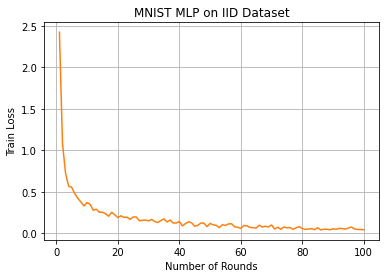

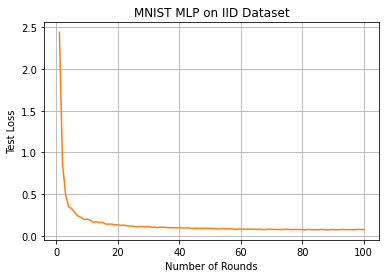

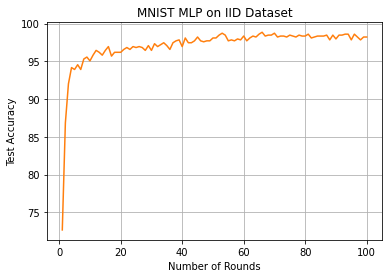

Training Done!
Total time taken to Train: 393.1269495487213


Experiment Run Number:  3
Round: 1... 	Average Loss: 2.304
Round: 2... 	Average Loss: 1.178
Round: 3... 	Average Loss: 0.754
Round: 4... 	Average Loss: 0.614
Round: 5... 	Average Loss: 0.501
Round: 6... 	Average Loss: 0.437
Round: 7... 	Average Loss: 0.424
Round: 8... 	Average Loss: 0.391
Round: 9... 	Average Loss: 0.378
Round: 10... 	Average Loss: 0.289
Round: 11... 	Average Loss: 0.272
Round: 12... 	Average Loss: 0.309
Round: 13... 	Average Loss: 0.3
Round: 14... 	Average Loss: 0.256
Round: 15... 	Average Loss: 0.286
Round: 16... 	Average Loss: 0.233
Round: 17... 	Average Loss: 0.265
Round: 18... 	Average Loss: 0.211
Round: 19... 	Average Loss: 0.24
Round: 20... 	Average Loss: 0.241
Round: 21... 	Average Loss: 0.17
Round: 22... 	Average Loss: 0.185
Round: 23... 	Average Loss: 0.172
Round: 24... 	Average Loss: 0.209
Round: 25... 	Average Loss: 0.167
Round: 26... 	Average Loss: 0.17
Round: 27... 	Average Loss: 0.189
Round: 2

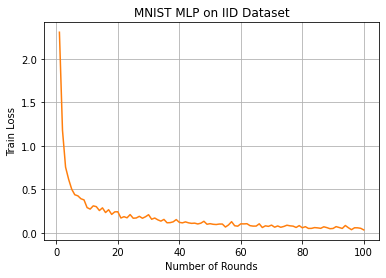

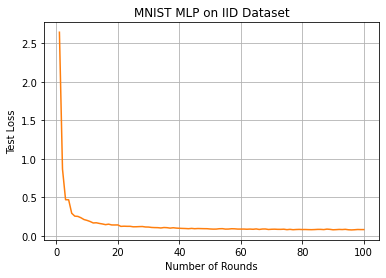

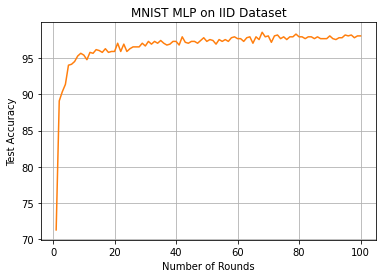

Training Done!
Total time taken to Train: 401.2156047821045


Experiment Run Number:  4
Round: 1... 	Average Loss: 2.17
Round: 2... 	Average Loss: 1.055
Round: 3... 	Average Loss: 0.696
Round: 4... 	Average Loss: 0.625
Round: 5... 	Average Loss: 0.506
Round: 6... 	Average Loss: 0.422
Round: 7... 	Average Loss: 0.439
Round: 8... 	Average Loss: 0.37
Round: 9... 	Average Loss: 0.332
Round: 10... 	Average Loss: 0.308
Round: 11... 	Average Loss: 0.336
Round: 12... 	Average Loss: 0.317
Round: 13... 	Average Loss: 0.286
Round: 14... 	Average Loss: 0.265
Round: 15... 	Average Loss: 0.246
Round: 16... 	Average Loss: 0.245
Round: 17... 	Average Loss: 0.227
Round: 18... 	Average Loss: 0.213
Round: 19... 	Average Loss: 0.223
Round: 20... 	Average Loss: 0.244
Round: 21... 	Average Loss: 0.201
Round: 22... 	Average Loss: 0.198
Round: 23... 	Average Loss: 0.181
Round: 24... 	Average Loss: 0.184
Round: 25... 	Average Loss: 0.168
Round: 26... 	Average Loss: 0.172
Round: 27... 	Average Loss: 0.164
Round

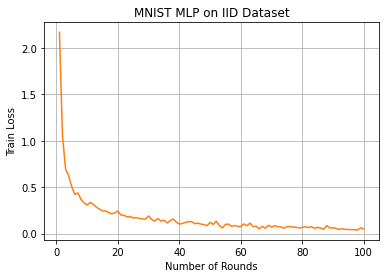

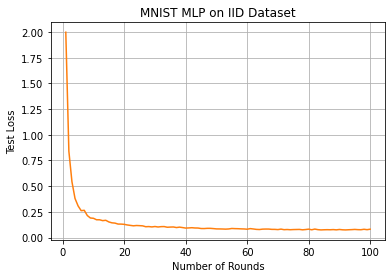

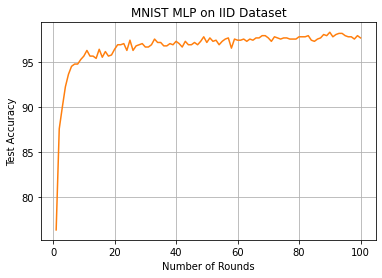

Training Done!
Total time taken to Train: 400.4998950958252




In [25]:
train_loss_multiple_runs = [None] * NUM_REPEAT
test_accuracy_multiple_runs = [None] * NUM_REPEAT
test_loss_multiple_runs = [None] * NUM_REPEAT

for exp_num in range(NUM_REPEAT):
  print("Experiment Run Number: ", exp_num)

  # number of training rounds
  rounds = 100
  # client fraction
  C = 0.1
  # number of clients
  K = 100
  # number of training passes on local dataset for each round
  E = 1
  # batch size
  batch_size = 10
  # learning Rate
  lr=0.1
  # dict containing different type of data partition
  data_dict = iid_partition(mnist_data_train, 100)
  # load model
  mnist_mlp = MNIST_2NN()

  if torch.cuda.is_available():
    mnist_mlp.cuda()

  mnist_mlp_iid_trained, train_loss, test_accuracy, test_loss = training(mnist_mlp, rounds, batch_size, lr, mnist_data_train, mnist_data_test, data_dict, C, K, E, "MNIST MLP on IID Dataset", "orange")
  
  train_loss_multiple_runs[exp_num] = train_loss
  test_accuracy_multiple_runs[exp_num] = test_accuracy
  test_loss_multiple_runs[exp_num] = test_loss

### Test

In [26]:
criterion = nn.CrossEntropyLoss()
acc, loss = testing(mnist_mlp_iid_trained, mnist_data_test, 128, criterion, num_classes, classes_test, True)

Test Loss: 0.081090

Test Accuracy of     0: 97% (74/76)
Test Accuracy of     1: 97% (88/90)
Test Accuracy of     2: 98% (90/91)
Test Accuracy of     3: 98% (72/73)
Test Accuracy of     4: 97% (87/89)
Test Accuracy of     5: 94% (64/68)
Test Accuracy of     6: 98% (61/62)
Test Accuracy of     7: 96% (78/81)
Test Accuracy of     8: 100% (77/77)
Test Accuracy of     9: 97% (81/83)

Final Test  Accuracy: 97.722 (772.0/790.0)


In [27]:
hyperparams = {'rounds': rounds,
               'C': C,
               'K': K,
               'E': E,
               'batch_size': batch_size,
               'lr': lr,
               }

log_dict['MNIST MLP on IID'] = {'train_loss': train_loss_multiple_runs, 
                                'test_loss': test_loss_multiple_runs, 
                                'test_accuracy': test_accuracy_multiple_runs,
                                'hyperparams': hyperparams,
                                }

## MNIST MLP on Non IID

### Train

Experiment Run Number:  0
Round: 1... 	Average Loss: 0.6
Round: 2... 	Average Loss: 0.43
Round: 3... 	Average Loss: 0.652
Round: 4... 	Average Loss: 0.311
Round: 5... 	Average Loss: 0.234
Round: 6... 	Average Loss: 0.132
Round: 7... 	Average Loss: 0.195
Round: 8... 	Average Loss: 0.201
Round: 9... 	Average Loss: 0.118
Round: 10... 	Average Loss: 0.086
Round: 11... 	Average Loss: 0.122
Round: 12... 	Average Loss: 0.235
Round: 13... 	Average Loss: 0.153
Round: 14... 	Average Loss: 0.144
Round: 15... 	Average Loss: 0.155
Round: 16... 	Average Loss: 0.148
Round: 17... 	Average Loss: 0.092
Round: 18... 	Average Loss: 0.132
Round: 19... 	Average Loss: 0.182
Round: 20... 	Average Loss: 0.099
Round: 21... 	Average Loss: 0.091
Round: 22... 	Average Loss: 0.094
Round: 23... 	Average Loss: 0.045
Round: 24... 	Average Loss: 0.172
Round: 25... 	Average Loss: 0.073
Round: 26... 	Average Loss: 0.116
Round: 27... 	Average Loss: 0.1
Round: 28... 	Average Loss: 0.094
Round: 29... 	Average Loss: 0.089
Ro

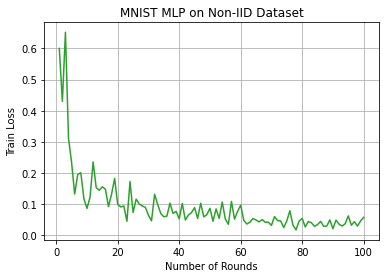

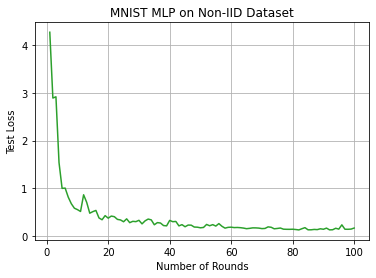

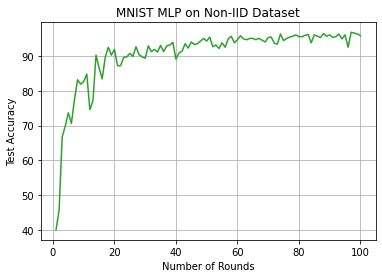

Training Done!
Total time taken to Train: 399.214524269104


Experiment Run Number:  1
Round: 1... 	Average Loss: 0.92
Round: 2... 	Average Loss: 0.571
Round: 3... 	Average Loss: 0.404
Round: 4... 	Average Loss: 0.215
Round: 5... 	Average Loss: 0.263
Round: 6... 	Average Loss: 0.215
Round: 7... 	Average Loss: 0.229
Round: 8... 	Average Loss: 0.273
Round: 9... 	Average Loss: 0.131
Round: 10... 	Average Loss: 0.105
Round: 11... 	Average Loss: 0.179
Round: 12... 	Average Loss: 0.096
Round: 13... 	Average Loss: 0.157
Round: 14... 	Average Loss: 0.123
Round: 15... 	Average Loss: 0.15
Round: 16... 	Average Loss: 0.167
Round: 17... 	Average Loss: 0.113
Round: 18... 	Average Loss: 0.068
Round: 19... 	Average Loss: 0.139
Round: 20... 	Average Loss: 0.066
Round: 21... 	Average Loss: 0.085
Round: 22... 	Average Loss: 0.09
Round: 23... 	Average Loss: 0.169
Round: 24... 	Average Loss: 0.122
Round: 25... 	Average Loss: 0.094
Round: 26... 	Average Loss: 0.077
Round: 27... 	Average Loss: 0.095
Round: 

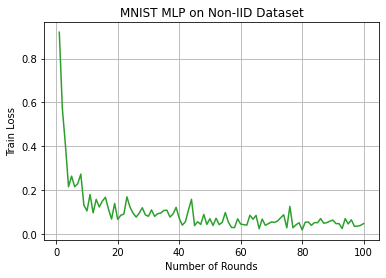

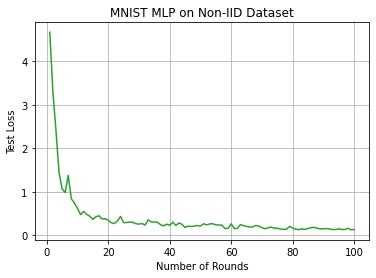

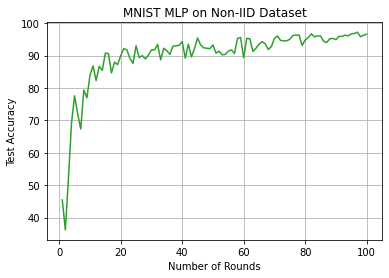

Training Done!
Total time taken to Train: 399.33024191856384


Experiment Run Number:  2
Round: 1... 	Average Loss: 0.574
Round: 2... 	Average Loss: 0.358
Round: 3... 	Average Loss: 0.409
Round: 4... 	Average Loss: 0.47
Round: 5... 	Average Loss: 0.267
Round: 6... 	Average Loss: 0.27
Round: 7... 	Average Loss: 0.129
Round: 8... 	Average Loss: 0.235
Round: 9... 	Average Loss: 0.135
Round: 10... 	Average Loss: 0.087
Round: 11... 	Average Loss: 0.106
Round: 12... 	Average Loss: 0.18
Round: 13... 	Average Loss: 0.209
Round: 15... 	Average Loss: 0.097
Round: 16... 	Average Loss: 0.129
Round: 17... 	Average Loss: 0.146
Round: 18... 	Average Loss: 0.084
Round: 19... 	Average Loss: 0.125
Round: 20... 	Average Loss: 0.143
Round: 21... 	Average Loss: 0.087
Round: 22... 	Average Loss: 0.179
Round: 23... 	Average Loss: 0.058
Round: 24... 	Average Loss: 0.113
Round: 25... 	Average Loss: 0.079
Round: 26... 	Average Loss: 0.093
Round: 27... 	Average Loss: 0.098
Round: 28... 	Average Loss: 0.053
Round

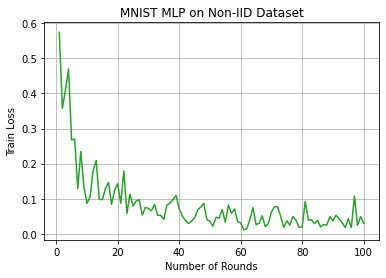

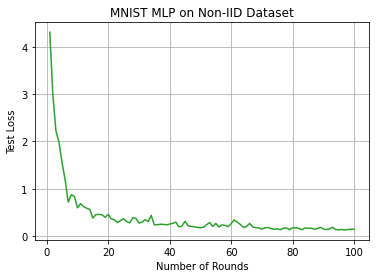

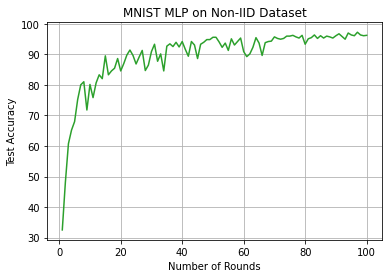

Training Done!
Total time taken to Train: 405.5230474472046


Experiment Run Number:  3
Round: 1... 	Average Loss: 0.66
Round: 2... 	Average Loss: 0.68
Round: 3... 	Average Loss: 0.474
Round: 4... 	Average Loss: 0.28
Round: 5... 	Average Loss: 0.25
Round: 6... 	Average Loss: 0.279
Round: 7... 	Average Loss: 0.162
Round: 8... 	Average Loss: 0.181
Round: 9... 	Average Loss: 0.126
Round: 10... 	Average Loss: 0.346
Round: 11... 	Average Loss: 0.173
Round: 12... 	Average Loss: 0.092
Round: 13... 	Average Loss: 0.197
Round: 14... 	Average Loss: 0.099
Round: 15... 	Average Loss: 0.104
Round: 16... 	Average Loss: 0.084
Round: 17... 	Average Loss: 0.143
Round: 18... 	Average Loss: 0.266
Round: 19... 	Average Loss: 0.085
Round: 20... 	Average Loss: 0.109
Round: 21... 	Average Loss: 0.079
Round: 22... 	Average Loss: 0.125
Round: 23... 	Average Loss: 0.095
Round: 24... 	Average Loss: 0.105
Round: 25... 	Average Loss: 0.189
Round: 26... 	Average Loss: 0.071
Round: 27... 	Average Loss: 0.079
Round: 

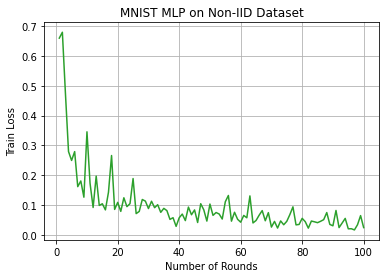

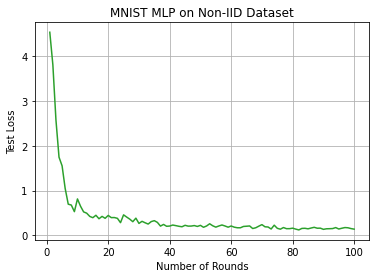

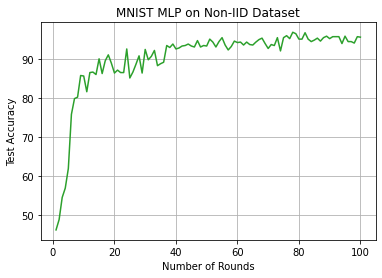

Training Done!
Total time taken to Train: 405.87967562675476


Experiment Run Number:  4
Round: 1... 	Average Loss: 0.491
Round: 2... 	Average Loss: 0.561
Round: 3... 	Average Loss: 0.483
Round: 4... 	Average Loss: 0.338
Round: 5... 	Average Loss: 0.436
Round: 6... 	Average Loss: 0.223
Round: 7... 	Average Loss: 0.191
Round: 8... 	Average Loss: 0.135
Round: 9... 	Average Loss: 0.162
Round: 10... 	Average Loss: 0.132
Round: 11... 	Average Loss: 0.159
Round: 12... 	Average Loss: 0.137
Round: 13... 	Average Loss: 0.133
Round: 14... 	Average Loss: 0.122
Round: 15... 	Average Loss: 0.126
Round: 16... 	Average Loss: 0.088
Round: 17... 	Average Loss: 0.164
Round: 18... 	Average Loss: 0.111
Round: 19... 	Average Loss: 0.155
Round: 20... 	Average Loss: 0.099
Round: 21... 	Average Loss: 0.139
Round: 22... 	Average Loss: 0.117
Round: 23... 	Average Loss: 0.093
Round: 24... 	Average Loss: 0.038
Round: 25... 	Average Loss: 0.109
Round: 26... 	Average Loss: 0.181
Round: 27... 	Average Loss: 0.109
Ro

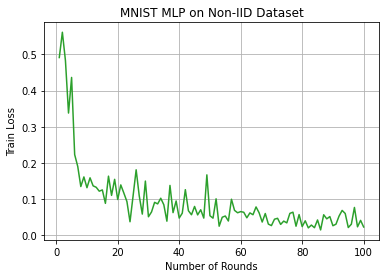

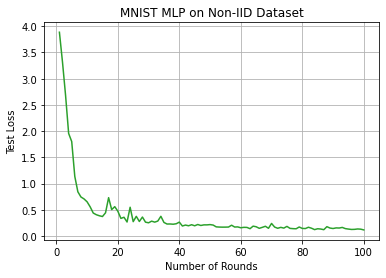

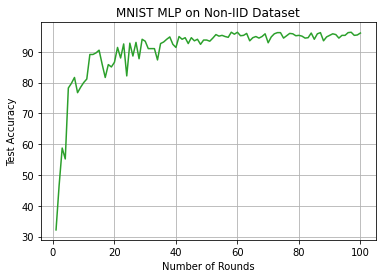

Training Done!
Total time taken to Train: 408.444785118103




In [28]:
train_loss_multiple_runs = [None] * NUM_REPEAT
test_accuracy_multiple_runs = [None] * NUM_REPEAT
test_loss_multiple_runs = [None] * NUM_REPEAT

for exp_num in range(NUM_REPEAT):
  print("Experiment Run Number: ", exp_num)
  
  # number of training rounds
  rounds = 100
  # client fraction
  C = 0.1
  # number of clients
  K = 100
  # number of training passes on local dataset for each roung
  E = 1
  # batch size
  batch_size = 10
  # learning Rate
  lr=0.1
  # dict containing different type of data partition
  data_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)
  # load model
  mnist_mlp = MNIST_2NN()

  if torch.cuda.is_available():
    mnist_mlp.cuda()

  mnist_mlp_non_iid_trained, train_loss, test_accuracy, test_loss = training(mnist_mlp, rounds, batch_size, lr, mnist_data_train, mnist_data_test, data_dict, C, K, E, "MNIST MLP on Non-IID Dataset", "green")

  train_loss_multiple_runs[exp_num] = train_loss
  test_accuracy_multiple_runs[exp_num] = test_accuracy
  test_loss_multiple_runs[exp_num] = test_loss

### Test

In [29]:
criterion = nn.CrossEntropyLoss() 
acc, loss = testing(mnist_mlp_non_iid_trained, mnist_data_test, 128, criterion, num_classes, classes_test, True)

Test Loss: 0.116706

Test Accuracy of     0: 98% (75/76)
Test Accuracy of     1: 96% (87/90)
Test Accuracy of     2: 97% (89/91)
Test Accuracy of     3: 94% (69/73)
Test Accuracy of     4: 97% (87/89)
Test Accuracy of     5: 92% (63/68)
Test Accuracy of     6: 91% (57/62)
Test Accuracy of     7: 92% (75/81)
Test Accuracy of     8: 98% (76/77)
Test Accuracy of     9: 97% (81/83)

Final Test  Accuracy: 96.076 (759.0/790.0)


In [30]:
hyperparams = {'rounds': rounds,
               'C': C,
               'K': K,
               'E': E,
               'batch_size': batch_size,
               'lr': lr,
               }

log_dict['MNIST MLP on Non IID'] = {'train_loss': train_loss_multiple_runs, 
                                'test_loss': test_loss_multiple_runs, 
                                'test_accuracy': test_accuracy_multiple_runs,
                                'hyperparams': hyperparams,
                                }

## Pickle Log

In [33]:
import pickle
 
with open(path + 'Local_Round_1_FedAvg.pkl', 'wb') as file:
  pickle.dump(log_dict, file)

In [34]:
log_dict

{'MNIST CNN on IID': {'hyperparams': {'C': 0.1,
   'E': 1,
   'K': 100,
   'batch_size': 10,
   'lr': 0.1,
   'rounds': 100},
  'test_accuracy': [[79.62025316455696,
    88.22784810126582,
    94.55696202531645,
    96.07594936708861,
    96.07594936708861,
    96.9620253164557,
    96.70886075949367,
    97.46835443037975,
    97.9746835443038,
    97.59493670886076,
    97.9746835443038,
    98.35443037974683,
    98.22784810126582,
    98.22784810126582,
    98.60759493670886,
    98.73417721518987,
    98.35443037974683,
    98.60759493670886,
    99.11392405063292,
    98.60759493670886,
    99.36708860759494,
    99.24050632911393,
    99.24050632911393,
    99.24050632911393,
    99.24050632911393,
    99.49367088607595,
    99.11392405063292,
    99.24050632911393,
    99.49367088607595,
    99.49367088607595,
    99.11392405063292,
    99.24050632911393,
    99.11392405063292,
    99.36708860759494,
    99.62025316455696,
    99.49367088607595,
    99.49367088607595,
    99.11

In [39]:
print([test_acc[-1] for test_acc in log_dict['MNIST CNN on IID']['test_accuracy']])

[99.62025316455696, 99.74683544303798, 99.49367088607595, 99.62025316455696, 99.11392405063292]


In [40]:
print([test_acc[-1] for test_acc in log_dict['MNIST CNN on Non IID']['test_accuracy']])

[96.20253164556962, 98.73417721518987, 9.620253164556962, 95.82278481012658, 97.46835443037975]


In [41]:
print([test_acc[-1] for test_acc in log_dict['MNIST MLP on IID']['test_accuracy']])

[97.9746835443038, 97.72151898734177, 98.22784810126582, 98.10126582278481, 97.72151898734177]


In [42]:
print([test_acc[-1] for test_acc in log_dict['MNIST MLP on Non IID']['test_accuracy']])

[95.82278481012658, 96.58227848101266, 96.20253164556962, 95.69620253164557, 96.07594936708861]
